<a href="https://colab.research.google.com/github/nikitaoltyan/ML-Homework/blob/main/Assignment5/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%matplotlib inline


Fine Tuning and Transfer Learning 
==============================================

В этом задании мы натренируем предобученную нейросеть с помощью tranfer learning для решения задачи классификации муравьев и пчел.

Тренировка нейросети со случайными начальными весами слоев требует большого количества данных и затрат времени на обучение.  
Поэтому на практике используют модели (архитектура + веса), которые обучались на больших стандартных датасетах.  

Для дообучения обычно используют два различных сценария:  
- **Finetuning** - дообучение параметров всех слоев нейросети. Параметры не случайны, а получены в ходе обучения модели на большом датасете, например ImageNet (1000 классов, миллионы изображений). Функции forward и backward вызываются для всех слоев. 
- **Feature extraction** - дообучаются только последние слои. Используются как правило линейные слои, их может быть один или несколько. Параметры предобученных слоев в процесее обучения не изменяются. В целом, работу предобученной части нейросети можно представить как извлечение некоторых абстрактрых признаков, на основании которых последние слои позволяют отнести входное изображение к тому или иному классу. Функции forward вызываются для всех слоев, а backward только для дообучаемых.

Итак, план действий таков:  

1. Импорт необходимых модулей
2. Загрузка, нормализация и аугментация данных
3. Определение процесса тренировки нейросети и визуализации результатов
4. Дообучение всех слоев нейросети, предобученных на большом датасете (Fine Tuning)
5. Обучение только последнего линейного слоя (Transfer Learning)

## 1. Импорт модулей

In [4]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

## 2. Загрузка данных

We will use torchvision and torch.utils.data packages for loading the
data.

Для загрузки данных воспользуемся готовыми инструментами из модуля `torchvision` и `torch.utils`:
- `datasets.ImageFolder` - создает датасет из изображений, разложенных по папкам `train` и `val`
- `data.DataLoader` - итератор по датасету
- `transforms.Compose` - цепочка предобработки данных


The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

Датасет с изображениями пчел и муравьев представляет собой очень малую подвыборку `ImageNet`
Изображения имеют разный размер, около  400 на 400 пикселей RGB.
На каждый класс приходится около 120 обучающих изображений и 70 тестовых.

Данные доступны по ссылке
   `<https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_

In [5]:
# TODO загрузите данные и распакуйте в текущую папку
! wget "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
! unzip hymenoptera_data.zip

--2021-04-03 09:20:11--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.38.72, 99.86.38.106, 99.86.38.37, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.38.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   212MB/s    in 0.2s    

2021-04-03 09:20:11 (212 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/

In [6]:
# TODO добавьте preprocessing and augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Визуализируем несколько изображений c помощью TensorBoard, посмотрим на что они стали похожи после аугментаций.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


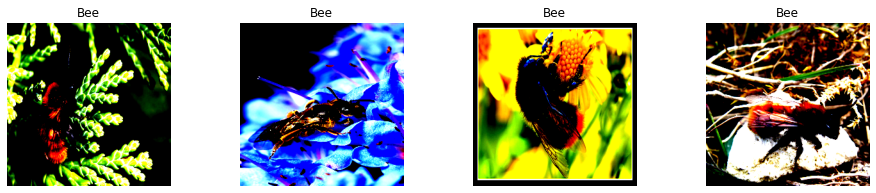

In [7]:
# TODO визуализация изображений с помощью tensorboard
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()
plt.figure(figsize=(16,3))

for i, index in enumerate(labels):
    plt.subplot(1,4,i+1)
    if index == 0:
        plt.title("Ant")
    else:
        plt.title("Bee")
    plt.imshow(images[i].permute(1, 2, 0))
    plt.grid(False)
    plt.axis('off')


## 3. Определение процесса тренировки нейросети

Напишите функцию тренировки нейросети, в которой реализованы следующие возможности:

- снижение learning rate
- сохранение модели с лучшими результатами
- использование одной функции как для фазы тренировки, так и валидации
- запись loss, train val accuracy в tensorboard

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # TODO Set model to training mode
                model.train()
            else:
                # TODO Set model to evaluate mode
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # TODO move inputs and labels to device
                inputs_gpu = inputs.to(device)
                labels_gpu = labels.to(device)
                # TODO zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs_gpu)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels_gpu)

                    if phase == 'train':
                        # TODO backward + optimize only if in training phase
                        loss.backward()
                        optimizer.step()


                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels_gpu.data)
                total_samples += labels_gpu.shape[0]
            if phase == 'train':
                scheduler.step()
            
            # TODO calculate loss and accuracy and write to tensorboard
            epoch_loss = running_loss / inputs.shape[0]
            epoch_acc = running_corrects / total_samples
            
            print(f'{phase} Loss: {epoch_loss} Acc: {epoch_acc}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60}m {time_elapsed % 60}s')
    print(f'Best val Acc: {best_acc}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Функция для визуализации предсказаний модели

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                image = inputs.cpu().data[j]
                plt.imshow(image.permute(1, 2, 0))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## 4. Finetuning всех весов

In [10]:
# TODO use pretrained model
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to num_classes.
model_ft.fc = nn.Linear(num_ftrs, num_classes)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.5 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.5)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


На CPU процесс обучения занимает несколько минут.

In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 41.07014176249504 Acc: 0.561475396156311
val Loss: 75.95560893416405 Acc: 0.7843137383460999

Epoch 1/9
----------
train Loss: 28.879064828157425 Acc: 0.8073769807815552
val Loss: 56.106245547533035 Acc: 0.8758170008659363

Epoch 2/9
----------
train Loss: 25.798905193805695 Acc: 0.8401638865470886
val Loss: 51.80816052854061 Acc: 0.8627451062202454

Epoch 3/9
----------
train Loss: 22.821355119347572 Acc: 0.8237704634666443
val Loss: 43.210665076971054 Acc: 0.9019607901573181

Epoch 4/9
----------
train Loss: 19.866301715373993 Acc: 0.8811475038528442
val Loss: 39.68804734572768 Acc: 0.915032684803009

Epoch 5/9
----------
train Loss: 18.24741018936038 Acc: 0.8729507923126221
val Loss: 36.4991325577721 Acc: 0.9281045794487

Epoch 6/9
----------
train Loss: 20.47517119348049 Acc: 0.8811475038528442
val Loss: 35.32463340461254 Acc: 0.9346405267715454

Epoch 7/9
----------
train Loss: 16.786492705345154 Acc: 0.9057376384735107
val Loss: 35.12558102491312 Acc: 0.9281045794487


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integ

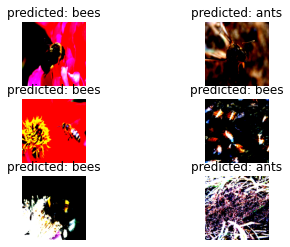

In [12]:
visualize_model(model_ft)

## 5. Trainsfer Learning (Feature extractor)

Теперь заморозим веса всех слоев модели, за исключением последнего. Для этого нужно установить параметр `requires_grad == False` для каждого слоя. Функция `backward` этих слоев не будет вызываться в процессе обучения, что весьма ускорит процесс.  

Более подробно `<https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.

In [14]:
model_conv = models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, num_classes)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

На CPU  обучение должно пройти примерно в два раза быстрее. 
Не забываем, что функция `forward` вычисляется по прежнему для всех слоев.

In [15]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 40.39378549158573 Acc: 0.6639344096183777
val Loss: 38.68847496062517 Acc: 0.9019607901573181

Epoch 1/9
----------
train Loss: 24.80104525759816 Acc: 0.8196721076965332
val Loss: 65.71326091143419 Acc: 0.8104575276374817

Epoch 2/9
----------
train Loss: 27.938970997929573 Acc: 0.8155737519264221
val Loss: 34.752940281294286 Acc: 0.9346405267715454

Epoch 3/9
----------
train Loss: 21.51754871197045 Acc: 0.860655665397644
val Loss: 39.30513695534319 Acc: 0.8888888955116272

Epoch 4/9
----------
train Loss: 29.091607161797583 Acc: 0.7909835577011108
val Loss: 27.12512046471238 Acc: 0.9215686321258545

Epoch 5/9
----------
train Loss: 20.424306442961097 Acc: 0.856557309627533
val Loss: 30.039088474586606 Acc: 0.9215686321258545

Epoch 6/9
----------
train Loss: 20.31416469346732 Acc: 0.8360655307769775
val Loss: 26.342242483980954 Acc: 0.9542483687400818

Epoch 7/9
----------
train Loss: 14.955634547397494 Acc: 0.8852458596229553
val Loss: 28.563178758136928 Acc: 0.954248368

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integ

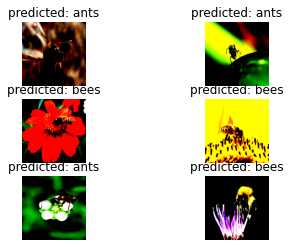

In [18]:
visualize_model(model_conv)